### **Import Libraries**

In [ ]:
import cv2
import copy
import math
import torch
import imageio
import PIL.Image
import numpy as np
import torch.nn as nn
import statistics as st
import tensorflow as tf
from scipy import signal
import imageio.v2 as imageio
from google.colab import drive
import matplotlib.pyplot as plt

datadir = "/content/"

Mounted at /content/drive


### **Guassian Filter Kernel**

In [ ]:
def gengaussian(size,sigma):
    if size%2==0 or size<2:
        print('Size Not Valid')
        return None
    kernel = np.zeros((size,size))
    for x in range(size):
        for y in range(size):
            kernel[x][y] = np.exp(-((x-(size-1)/2)**2 +(y-(size-1)/2)**2)/(2*sigma**2))
    kernel = kernel / np.sum(kernel)
    return kernel

### **Bounding Box Code**

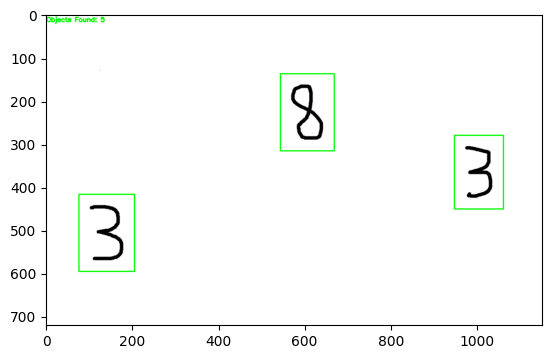

In [ ]:
#import image
image = cv2.imread(datadir + "test.jpg")

#Gaussian Blur
image_ = copy.deepcopy(image)
kernel = gengaussian(5, 3.0)
image_[:, :, 0] = signal.convolve2d(image[:, :, 0], kernel, mode='same')
image_[:, :, 1] = signal.convolve2d(image[:, :, 1], kernel, mode='same')
image_[:, :, 2] = signal.convolve2d(image[:, :, 2], kernel, mode='same')

#canny edge detection on grayscale image
canny = cv2.Canny(image, 50, 150,apertureSize=3)
# plt.imshow(cv2.cvtColor(canny, cv2.COLOR_BGR2RGB))

#finding the contours of each object in each image
(contours, _) = cv2.findContours(canny.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

#copy of image for edge boxes
con_image = image.copy()
edge_image = image.copy()

#draws contours around each object
cv2.drawContours(con_image, contours, -1, (255, 0, 0), 2)

#go through each contour and draw each boxes
cropped_images = []
cropped_images_x = []
count = 0
for contour in contours:
    count += 1
    x,y,w,h = cv2.boundingRect(contour)
    if (w*h < 1000):
      continue
    cv2.rectangle(edge_image,(x-25,y-25),(x+w+25,y+h+25),(0,255,0),2)
    cropped_object = np.asarray(image[y-25:y+h+25, x-25:x+w+25])
    cropped_images_x.append(x)
    cropped_images.append(cropped_object)

ordered_cropped_images = []
for i in range(len(cropped_images_x)):
  min = np.argmin(cropped_images_x)
  ordered_cropped_images.append(cropped_images[min])
  cropped_images.pop(min)
  cropped_images_x.pop(min)


detection = cv2.putText(edge_image, f"Objects Found: {count}", (0, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 2)
plt.imshow(cv2.cvtColor(edge_image, cv2.COLOR_BGR2RGB))

### **Display Cropped Images**

<ipython-input-78-0c3b3d5ee43e>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ordered_cropped_images = np.asarray(ordered_cropped_images)


3


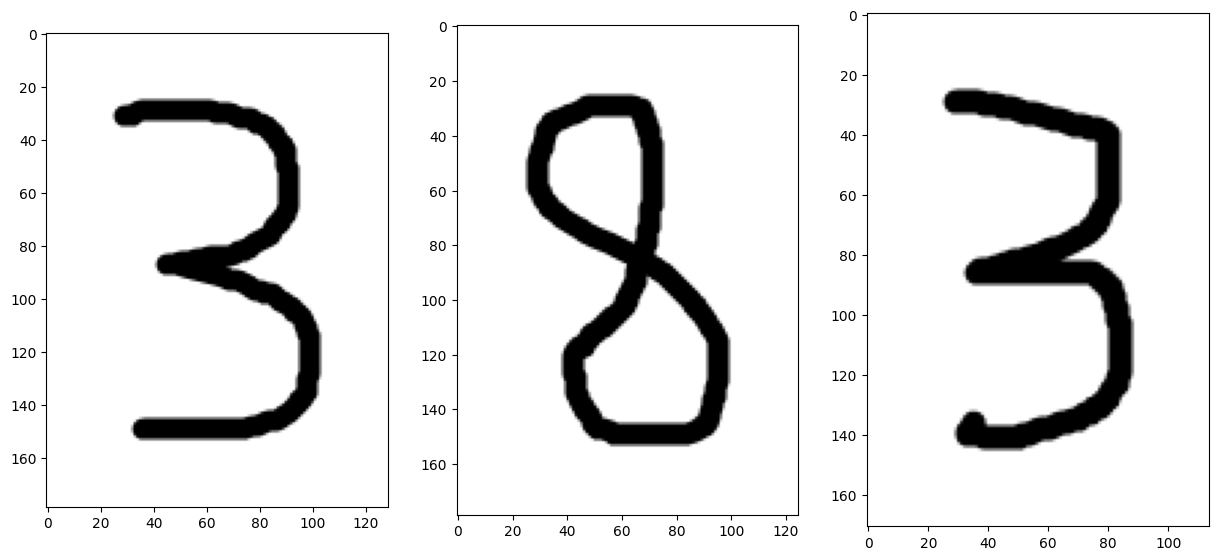

In [ ]:
#Cropped Objects
ordered_cropped_images = np.asarray(ordered_cropped_images)
num_of_img = np.shape(ordered_cropped_images)[0]
print(num_of_img)
plt.figure(figsize=(15,9))
plot_count = 1
for img in ordered_cropped_images:
    plt.subplot(1,num_of_img,plot_count)
    plt.imshow(ordered_cropped_images[plot_count-1])
    plot_count += 1

### **Import EMNIST**

In [ ]:
from keras.datasets import mnist

**Process Dataset**

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.reshape(x_train[:7500], (7500, 28*28))/255
y_train = y_train[:7500]
x_test = np.reshape(x_test[:5000], (5000, 28*28))/255
y_test = y_test[:5000]

11490434/11490434 [==============================] - 1s 0us/step


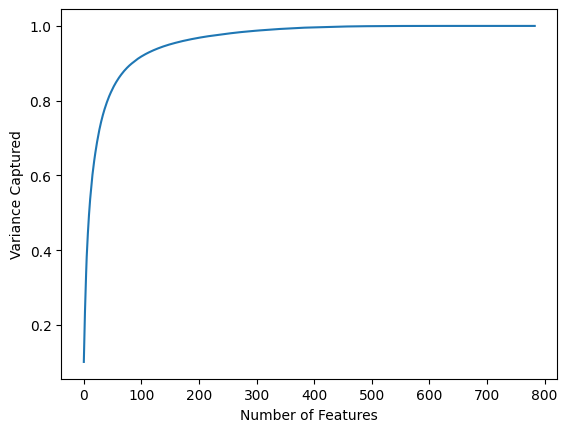

In [ ]:
mean = np.mean(x_train, axis=0)
cov = (np.transpose(x_train-mean)@(x_train-mean))/len(x_train)
val, vec = np.linalg.eig(cov)
totalVar = 0
for i in val:
  totalVar += i
plt.xlabel("Number of Features")
plt.ylabel("Variance Captured")
plt.plot(np.cumsum(val)/totalVar)

#~90% variance captured with 88 features
vec = vec[:88].transpose().real
x_train = np.matmul(x_train, vec)
x_test = np.matmul(x_test, vec)

### **Training**

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation = "relu"),
    tf.keras.layers.Dense(64, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "softmax")
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=tf.keras.metrics.SparseCategoricalAccuracy())
model.fit(x_train, y_train, epochs=50)

### **Display Input**

In [ ]:
def display_mnist(x, subplot_rows=1, subplot_cols=1):
  if subplot_rows>1 or subplot_cols>1:
    fig, ax = plt.subplots(subplot_rows, subplot_cols, figsize=(15,15))
    for i in np.arange(len(x)):
      ax[i].imshow(np.reshape(x[i], (28,28)), cmap='gray')
      ax[i].axis('off')
  else:
      plt.imshow(np.reshape(x, (28,28)), cmap='gray')
      plt.axis('off')
  plt.show()

### **Rescale and Resize Input**

In [ ]:
def bilinear(orig_img):
  orig_width, orig_height = orig_img.shape
  new_img = np.empty((28, 28))
  width_scale = orig_width/28
  height_scale = orig_height/28
  for i in range(28):
    for j in range(28):
      x_idx = i * width_scale
      y_idx = j * height_scale

      x_floor = math.floor(x_idx)
      if x_floor < 0:
        x_floor = 0

      y_floor = math.floor(y_idx)
      if y_floor < 0:
        y_floor = 0

      x_ceil = math.ceil(x_idx)
      if x_ceil > orig_width:
        x_ceil = orig_width

      y_ceil = math.ceil(y_idx)
      if y_ceil > orig_height:
        y_ceil = orig_height

      neigh1 = orig_img[x_floor, y_floor]
      neigh2 = orig_img[x_floor, y_ceil]
      neigh3 = orig_img[x_ceil, y_floor]
      neigh4 = orig_img[x_ceil, y_ceil]
      dist1 = math.dist([x_idx, y_idx], [x_floor, y_floor])
      dist2 = math.dist([x_idx, y_idx], [x_floor, y_ceil])
      dist3 = math.dist([x_idx, y_idx], [x_ceil, y_floor])
      dist4 = math.dist([x_idx, y_idx], [x_ceil, y_ceil])
      total = dist1+dist2+dist3+dist4
      if total == 0:
        new_img[i][j] = np.round(neigh1/4 + neigh2/4 + neigh3/4 + neigh4/4)
      else:
        new_img[i][j] = np.round(neigh1*(1-(dist1/total)) + neigh2*(1-(dist2/total)) + neigh3*(1-(dist3/total)) + neigh4*(1-(dist4/total)))

  return new_img


### **Display Processed Input**

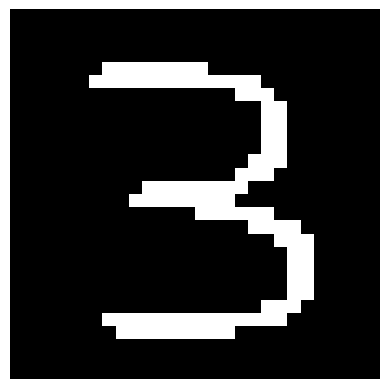

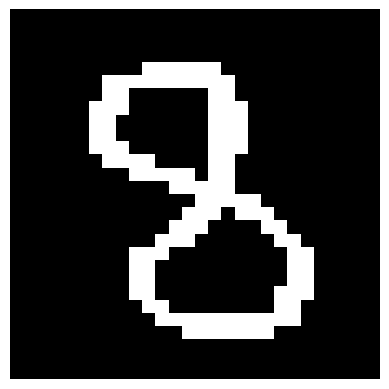

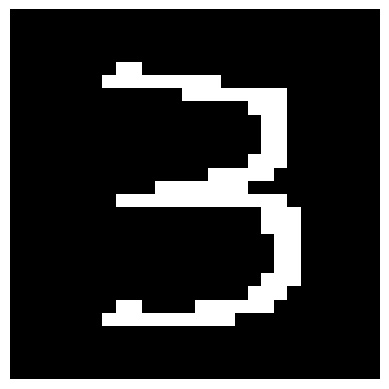

In [ ]:
input = np.empty((len(ordered_cropped_images),784))
count = 0
input = list(input)

for img in ordered_cropped_images:
    gray_img = np.zeros((img.shape[0],img.shape[1]))
    vector_img = np.zeros(28*28)


    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            gray_img[i][j] = (255 - (0.299*img[i][j][0] + 0.587*img[i][j][1] + 0.114*img[i][j][2]))/255

    scaled_img = bilinear(gray_img)
    vector_img = np.reshape(scaled_img, (28*28))

    for i in range(len(vector_img)):
      if vector_img[i] > 0.5:
        vector_img[i] = 1
      else:
        vector_img[i] = 0

    input[count] = vector_img
    count+=1

    display_mnist(vector_img)

### **Evaluate**

In [ ]:
results = np.argmax(model.predict(np.matmul(input,vec)), axis=1)
print("The numbers are:",results)

1/1 [==============================] - 0s 18ms/step
The numbers are: [3 8 3]
